This is final project for the course "Machine Learining in Graphs"

In [3]:
import pandas as pd
import networkx as nx
from consts import *
from build_graph import build_bi_partite_graph

import matplotlib.pyplot as plt
import numpy as np
from catboost import CatBoostClassifier
from matplotlib_venn import venn2
from tqdm.auto import tqdm

import data_utils
import graph_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [4]:
train_data = pd.read_csv("2021.csv")
train_data = pd.concat([train_data, pd.read_csv("2022.csv")])
train_data = pd.concat([train_data, pd.read_csv("2023.csv")])
validation_data = pd.read_csv("2024.csv")

In [5]:
print(f"Train data: {train_data.shape}")
print(f"Validation data: {validation_data.shape}")

Train data: (187245813, 3)
Validation data: (46788230, 3)


In [6]:
graph = build_bi_partite_graph(train_data, DRUG, REACTION)
print(graph)
nx.write_graphml(graph, "graph1.graphml")

validation_graph = build_bi_partite_graph(validation_data, DRUG, REACTION)
print(validation_graph)

Graph with 222193 nodes and 8272779 edges
Graph with 55018 nodes and 2601576 edges


<Axes: xlabel='log(degree)', ylabel='log(Count)'>

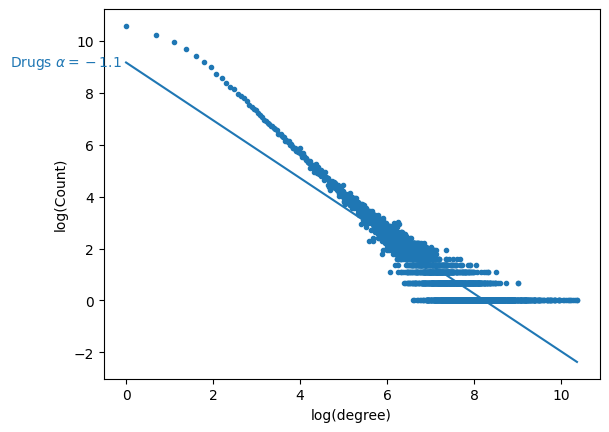

In [7]:
data_utils.plot_degree_distribiution(graph, "Drugs")

In [8]:
data = []
# run on 3% of the nodes
for _ in range (int(len(graph.nodes)*0.03)):
    u = np.random.choice(graph.nodes)
    v = np.random.choice(graph.nodes)
    has_edge = graph.has_edge(u, v)
    jaccard_coefficient = nx.jaccard_coefficient(graph, [(u, v)])
    adamic_adar_index = nx.adamic_adar_index(graph, [(u, v)])
    preferential_attachment = nx.preferential_attachment(graph, [(u, v)])
    common_neighbors = nx.common_neighbors(graph, u, v)
    resource_allocation_index = nx.resource_allocation_index(graph, [(u, v)])
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "jaccard_coefficient",
            "metric_value": list(jaccard_coefficient)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "adamic_adar_index",
            "metric_value": list(adamic_adar_index)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "preferential_attachment",
            "metric_value": list(preferential_attachment)[0][-1],
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "common_neighbors",
            "metric_value": len(list(common_neighbors)),
        }
    )
    data.append(
        {
            "u": u,
            "v": v,
            "has_edge": has_edge,
            "metric_name": "resource_allocation_index",
            "metric_value": list(resource_allocation_index)[0][-1],
        }
    )

df_metrics = pd.DataFrame(data)
df_metrics

,u,v,has_edge,metric_name,metric_value
0,FLUTICIASONE ? SALMETEROL (ADVAIR) 100?50 MCG/...,EVEROLIMUS TABLETS CE,False,jaccard_coefficient,0.0
1,FLUTICIASONE ? SALMETEROL (ADVAIR) 100?50 MCG/...,EVEROLIMUS TABLETS CE,False,adamic_adar_index,0.0
2,FLUTICIASONE ? SALMETEROL (ADVAIR) 100?50 MCG/...,EVEROLIMUS TABLETS CE,False,preferential_attachment,170.0
3,FLUTICIASONE ? SALMETEROL (ADVAIR) 100?50 MCG/...,EVEROLIMUS TABLETS CE,False,common_neighbors,0.0
4,FLUTICIASONE ? SALMETEROL (ADVAIR) 100?50 MCG/...,EVEROLIMUS TABLETS CE,False,resource_allocation_index,0.0
...,...,...,...,...,...
33320,"KIDS VITAMINS, MULTIVITAMINS",THC AND CBD,False,jaccard_coefficient,0.0
33321,"KIDS VITAMINS, MULTIVITAMINS",THC AND CBD,False,adamic_adar_index,0.0
33322,"KIDS VITAMINS, MULTIVITAMINS",THC AND CBD,False,preferential_attachment,3.0
33323,"KIDS VITAMINS, MULTIVITAMINS",THC AND CBD,False,common_neighbors,0.0


In [9]:
df_x = df_metrics.pivot_table(
    index=["u", "v"], columns="metric_name", values="metric_value"
).reset_index()
df_x

metric_name,u,v,adamic_adar_index,common_neighbors,jaccard_coefficient,preferential_attachment,resource_allocation_index
0,0.4 mg Tamsulosin,Prenatal vitamins dha prescribed,0.0,0.0,0.0,36.0,0.0
1,1 ALPHA OH VIT D2,"OXYCODONE (OXYCODONE HCL 40MG TAB, SA)",0.0,0.0,0.0,4.0,0.0
2,1 x daily Amlodipipine 5 mg,EPAROSE [EICOSAPENTAENOIC ACID],0.0,0.0,0.0,40.0,0.0
3,10 mg Montelukast sodium (Montelukast sodium),GINGER ROOT 550MG,0.0,0.0,0.0,6.0,0.0
4,10 mg Provera,HYDROCODIN,0.0,0.0,0.0,14.0,0.0
...,...,...,...,...,...,...,...
6660,woman^s once a day,TENOX,0.0,0.0,0.0,310.0,0.0
6661,women^s probiotic,LANOXIN PG,0.0,0.0,0.0,12.0,0.0
6662,yaz birth control,RA VITAMIN C,0.0,0.0,0.0,8.0,0.0
6663,zetia 10 mg,CLOPIXOL ACUPHASE,0.0,0.0,0.0,46.0,0.0


In [10]:


X = df_x.drop(columns=["u", "v"])
y = np.array(
    [
        graph.has_edge(row.u, row.v)
        for _, row in df_x.iterrows()
    ]
)
weight = np.array([1 if has_edge else 0.05 for has_edge in y])
y

array([False, False, False, ..., False, False, False])

In [11]:
X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(
    X, y, weight, test_size=0.2, random_state=42
)
# Check for data leakage
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

# Inspect the first few rows of the training data
print(X_train.head())
print(y_train[:5])


Training set size: (5332, 5)
Test set size: (1333, 5)
metric_name  adamic_adar_index  common_neighbors  jaccard_coefficient  \
380                   0.000000               0.0             0.000000   
5784                  0.105761               1.0             0.058824   
4590                  0.000000               0.0             0.000000   
121                   0.000000               0.0             0.000000   
2886                  0.000000               0.0             0.000000   

metric_name  preferential_attachment  resource_allocation_index  
380                            115.0                   0.000000  
5784                            77.0                   0.000078  
4590                            40.0                   0.000000  
121                              2.0                   0.000000  
2886                            12.0                   0.000000  
[False False False False False]


In [12]:
%matplotlib inline
model = CatBoostClassifier(
    n_estimators=500,
    learning_rate=0.001,
    depth=12,
    eval_metric="AUC",
    loss_function="Logloss",
    l2_leaf_reg=4,
    verbose=False,
)
model.fit(
    X_train,
    y_train,
    sample_weight=weight_train,
    eval_set=(X_test, y_test),
    early_stopping_rounds=150,
    plot=True,
    verbose=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.0000000	best: 0.0000000 (0)	total: 268ms	remaining: 2m 13s
1:	test: 0.0000000	best: 0.0000000 (0)	total: 353ms	remaining: 1m 27s
2:	test: 0.0000000	best: 0.0000000 (0)	total: 451ms	remaining: 1m 14s
3:	test: 0.0000000	best: 0.0000000 (0)	total: 535ms	remaining: 1m 6s
4:	test: 0.0000000	best: 0.0000000 (0)	total: 549ms	remaining: 54.4s
5:	test: 0.0000000	best: 0.0000000 (0)	total: 632ms	remaining: 52.1s
6:	test: 0.0000000	best: 0.0000000 (0)	total: 714ms	remaining: 50.3s
7:	test: 0.0000000	best: 0.0000000 (0)	total: 804ms	remaining: 49.4s
8:	test: 0.0000000	best: 0.0000000 (0)	total: 816ms	remaining: 44.5s
9:	test: 0.0000000	best: 0.0000000 (0)	total: 900ms	remaining: 44.1s
10:	test: 0.0000000	best: 0.0000000 (0)	total: 986ms	remaining: 43.8s
11:	test: 0.0000000	best: 0.0000000 (0)	total: 1.07s	remaining: 43.5s
12:	test: 0.0000000	best: 0.0000000 (0)	total: 1.16s	remaining: 43.3s
13:	test: 0.0000000	best: 0.0000000 (0)	total: 1.24s	remaining: 43.2s
14:	test: 0.0000000	best: 0

<Axes: title={'center': 'Feature importance'}, ylabel='metric_name'>

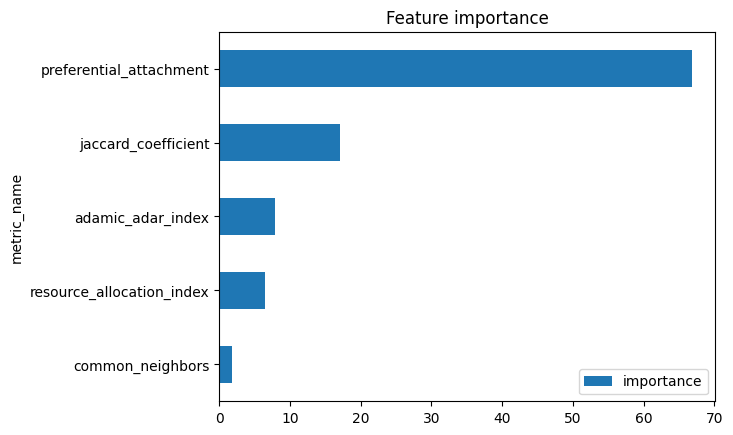

In [13]:
feature_importance = (
    pd.DataFrame(
        model.get_feature_importance(), index=X.columns, columns=["importance"]
    )
    .sort_values("importance", ascending=True)
    .tail(30)
)
feature_importance.plot(kind="barh", title="Feature importance")

The node XOLAIR has 186 new neighbors.
Reactions len: 19229


Processing reaction nodes:   0%|          | 0/19229 [00:00<?, ?it/s]

Running prediction:
Predicted: 19229


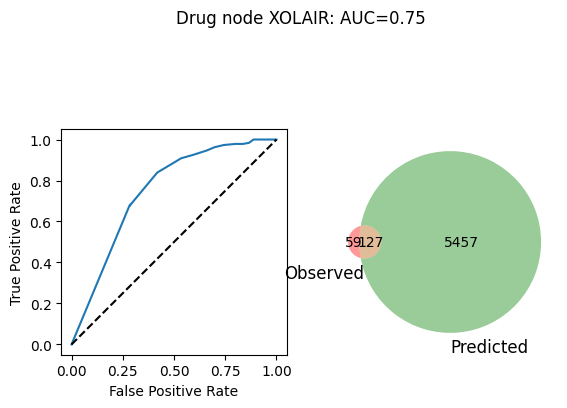

In [14]:
# Extract edges from both graphs
edges_in_graph = set(graph.edges())
edges_in_validation_graph = set(validation_graph.edges())

# Find new edges in validation_graph that are not in graph
new_edges = edges_in_validation_graph - edges_in_graph

# Convert the set of new edges to a DataFrame
new_edges = pd.DataFrame(list(new_edges), columns=[DRUG, REACTION])

# Check the nodes of the edges exist in the original graph
new_edges = new_edges[
    new_edges[DRUG].apply(lambda x: x in graph.nodes)
    & new_edges[REACTION].apply(lambda x: x in graph.nodes)
]


def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")
    
    if not n_added:
        return
    
    to_predict_x = []
    to_predict_y = []
    
    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue
        
        u, v = (target, drug)
        
        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])
        
        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })
        
        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )
        # print(f"Added edge: {u}, {v}")
    
    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")
    
    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )
    
    fig.suptitle(f"Drug node {drug}: AUC={roc_auc:.2f}")
    plt.show()
    
check_prediction("XOLAIR", new_edges, graph)

The node XOLAIR has 193 new neighbors.
Reactions len: 19229


Processing reaction nodes:   0%|          | 0/19229 [00:00<?, ?it/s]

Observed: 15791
Running prediction:
Predicted: 15791


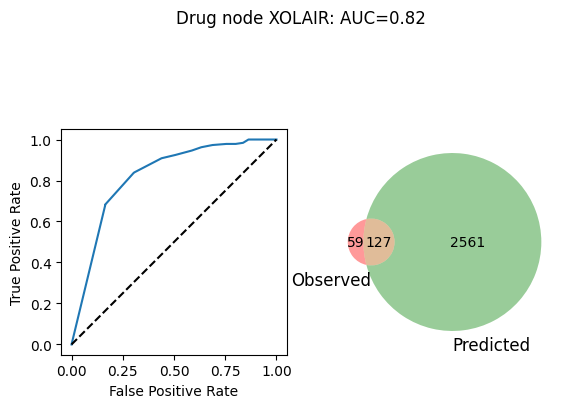

In [15]:
# new_edges = validation_graph[ (validation_graph[DRUG], validation_graph[REACTION]) not in graph.edges() ]

# Extract edges from both graphs
edges_in_graph = set(graph.edges())
edges_in_validation_graph = set(validation_graph.edges())

# Find new edges in validation_graph that are not in graph
new_edges = edges_in_validation_graph - edges_in_graph

# Convert the set of new edges to a DataFrame
new_edges = pd.DataFrame(list(new_edges), columns=[DRUG, REACTION])


def check_prediction(drug, newly_added_edges, graph_before, cutoff=0.5):
    newly_added_edges_to_drug = newly_added_edges[newly_added_edges[DRUG] == drug]
    n_added = newly_added_edges_to_drug.shape[0]
    print(f"The node {drug} has {n_added:,} new neighbors.")
    
    if not n_added:
        return
    
    to_predict_x = []
    to_predict_y = []
    
    reaction_nodes = [node for node, data in graph_before.nodes(data=True) if data['type'] == REACTION]
    print(f"Reactions len: {len(reaction_nodes)}")
    for target in tqdm(reaction_nodes, desc="Processing reaction nodes"):
        if target == drug:
            continue
            
        if graph_before.has_edge(target, drug):
            continue
        
        u, v = (target, drug)
        
        jaccard_coefficient = nx.jaccard_coefficient(graph_before, [(u, v)])
        adamic_adar_index = nx.adamic_adar_index(graph_before, [(u, v)])
        preferential_attachment = nx.preferential_attachment(graph_before, [(u, v)])
        common_neighbors = nx.common_neighbors(graph_before, u, v)
        resource_allocation_index = nx.resource_allocation_index(graph_before, [(u, v)])
        
        x_other = pd.Series({
            "adamic_adar_index": list(adamic_adar_index)[0][-1],
            "common_neighbors": len(list(common_neighbors)),
            "jaccard_coefficient": list(jaccard_coefficient)[0][-1],
            "preferential_attachment": list(preferential_attachment)[0][-1],
            "resource_allocation_index": list(resource_allocation_index)[0][-1],
        })
        
        to_predict_x.append(x_other)
        to_predict_y.append(
            newly_added_edges[
                (newly_added_edges[DRUG] == drug) & (newly_added_edges[REACTION] == target)
            ].shape[0] > 0
        )
        # print(f"Added edge: {u}, {v}")
    
    to_predict_x = pd.DataFrame(to_predict_x)
    observed = np.array(to_predict_y)
    print(f"Observed: {observed.shape[0]}")
    print("Running prediction:")
    predicted_proba = model.predict_proba(to_predict_x)
    predicted = predicted_proba[:, 1] > cutoff
    print(f"Predicted: {predicted.shape[0]}")
    fpr, tpr, _ = roc_curve(y_true=observed, y_score=predicted_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    fig, axes = plt.subplots(ncols=2)
    
    ax = axes[0]
    ax.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax.plot([0, 1], [0, 1], "k--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_aspect("equal")
    
    ax = axes[1]
    venn2(
        subsets=(set(np.where(observed)[0]), set(np.where(predicted)[0])),
        set_labels=("Observed", "Predicted"),
        ax=ax,
    )
    
    fig.suptitle(f"Drug node {drug}: AUC={roc_auc:.2f}")
    plt.show()
    
check_prediction("XOLAIR", new_edges, graph)